# BIOMEDIN 260/RAD260: Problem Set 3 - Mammogram Project

## Spring 2019

## Name 1:

Karina Samuel-Gama

## Name 2:

Areli Valencia

## Introduction

Breast cancer has the highest incidence and second highest mortality rate for women in the US.

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Turning in a deep dream assignment using mammograms might be amusing, for example, but not so useful to patients. That being said, choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, at least in BMI 260."

Treat this as a mini-project. We highly encourage working with 1 other person, possibly someone in your main project team. 

In addition to the mammograms themselves, the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You don't need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on those features using the algorithms presented to you in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any of the code we went over in class or use your own (custom code, sklearn, keras, Tensorflow etc.). If you dont want to place helper functions and classes into this notebook, place them in a `.py` file in the same folder called `helperfunctions.py` and import them into this notebook.

## Data

The data is here:

https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

## Grading and Submission

This assignment has 3 components: code, figures (outputs/analyses of your code), and a write-up detailing your mini-project. You will be graded on these categories.

If you're OK with Python or R, please place all three parts into this notebook/.Rmd file that we have provided where indicated. We have written template sections for you to follow for simplicity/completeness. When you're done, save as a `.pdf` (please knit to `.pdf` if you are using `.Rmd`, or knit to `.html` and use a browser's "Print" function to convert to `.pdf`).

If you don't like Python OR R, we will allow you to use a different language, but please turn your assignment in with: 1) a folder with all your code, 2) a folder with all your figures, and 3) a `.tex`/`.doc`/`.pdf` file with a write-up.

## Title: Classification of Benign and Malignant Breast Tumors 

In [52]:
import os
import cv2
import skimage

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import mahotas as mt

from PIL import Image 
from skimage import io 
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border 
from skimage.morphology import remove_small_objects 
from skimage.morphology import binary_closing


In [11]:
df = pd.read_csv("./breast_metadata.csv")

**1. Describe what you are doing and why it matters to patients using at least one citation.**

YOUR WRITTEN ANSWER TO QUESTION 1 HERE

**2. Describe the relevant statistics of the data. How were the images taken? How were they labeled? What is the class balance and majority classifier accuracy? How will you divide the data into testing, training and validation sets?**

In [51]:
print "There are " + str(len(df)) + " unique images with the following subset breakdown\n" + str(df.nunique()) + "\nand the following calss balance \n" + str(df['label'].value_counts())

There are 2076 unique images with the following subset breakdown
id       1041
side        2
view        2
label       2
dtype: int64
and the following calss balance 
0    1079
1     997
Name: label, dtype: int64


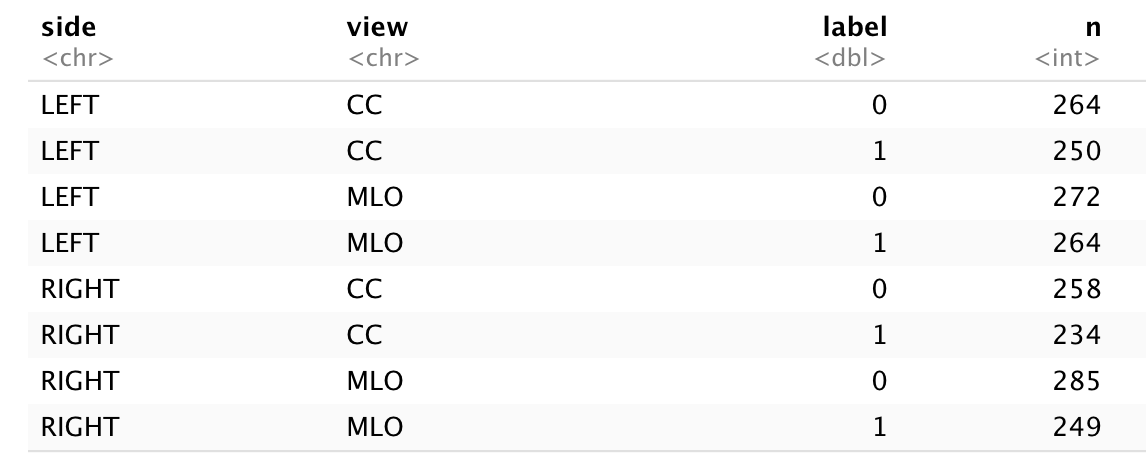ass_count.png)

This dataset consist of 2076 breast mammographs taken from two views craniocaudal (CC) and mediolateral oblique (MLO) since the two views are not orthogonal the localization of any lesion found using these images will require some transformation back to 3d space. Using a mix of python and R we were able to determine that there are no duplicate labels in the dataset and that there were roughly equal numbers of positve and negative images in the dataset. The majority classifier accuracy is ~ 52%. Dividing the image by side, view and label we see that there are roughly ~250 images per group. This fairly even proportion will help minimize any training artifacts. 

Given that there are 2076 images we plan to split the data into a 70, 20, 10 split between training, development and test sets. We can use data augmentation (flipping and rotation) to further increase numbers in the training set. 

**3. Describe your data pipeline (how is the data scrubbed, normalized, stored, and fed to the model for training?).**

In [ ]:
np.divide(np.subtract(vol32, np.min(vol32)), np.subtract(np.max(vol32 ), np.min(vol32)))

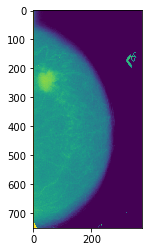

In [67]:
# test case of one image - segmentation and feature extraction

# patient number 01262 right breast, mlo view positive tumor
#scan_path = "/Users/ksamgam/Downloads/breast_mg/P_01262_RIGHT_MLO.tif"
scan_path = "/Users/arelivalencia/Desktop/Images/P_01556_LEFT_CC.tif"
orig_img = io.imread(scan_path)

# Resize image to 750 x 375
resize_img = cv2.resize(orig_img, dsize = (375,750), interpolation=cv2.INTER_NEAREST)
resize_img = resize_img.astype('float32') ## COMMENT OUT THIS LINE TO SEE WHAT RESCALING DOES in UINT16

# Normalize images
normalize_img = np.divide(np.subtract(resize_img, np.min(resize_img)),
                          np.subtract(np.max(resize_img ), np.min(resize_img)))

# DO WE WANT TO SCALE BY Z_SCORE (PROTECT AGAINST OUTLIERS)?? 
# Yes I think we should scale by z-score but had some issues.  
#scaled_img = np.divide(np.subtract(normalize_img, np.mean(normalize_img)),
#                            np.std(normalize_img))

# view image
plt.imshow(normalize_img)                           


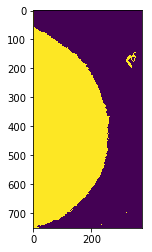

In [97]:
# Segmentation with Otsu's threshold - Do we want to do the smoothing thing we did in Pset1??
oned_img = normalize_img.ravel()
nonzero_oned = oned_img[oned_img > 0]
thresh = threshold_otsu(nonzero_oned)

#Attempt at smoothing but not sure if doing it correctly 
image = normalize_img > thresh 
labeled_img = skimage.measure.label(image, neighbors=4)
filtered_img = remove_small_objects(labeled_img, min_size=0.1, connectivity=4)
smoothed_img = binary_closing(filtered_img)

plt.imshow(smoothed_img)


In [99]:
int_img = np.multiply(smoothed_img, 255).astype('int')

# Feature Extraction
textures = mt.features.haralick(int_img)

#HU_moments doesn't work when I feed it the smoothed_img or int_img. It only works with normalize_img 
hu_moments = cv2.HuMoments(cv2.moments(normalize_img)).flatten()

# take the mean of it and return it
ht_mean = textures.mean(axis=0)

print ht_mean
print hu_moments

[ 4.97163653e-01  2.87585775e+02  9.91126805e-01  1.62053179e+04
  9.95577373e-01  2.40727310e+02  6.45336860e+04  1.03421951e+00
  1.03864220e+00  3.85659367e-03  4.09134787e-02 -9.59003866e-01
  9.23286090e-01]
[ 4.63960612e-01  1.04407611e-01  1.19143431e-02  6.73483142e-04
 -1.09951004e-06 -1.75221692e-04  1.55905402e-06]


YOUR WRITTEN ANSWER TO QUESTION 3 HERE

#Is it ok if we use only the 20GB of data instead of 160GB of data? If so, any suggestions on splitting the data between training, testing, and validation? 

#What do they mean by scrubbing data? 
- Everything in the same format (sizes of the images so that they're all the same resolutions) 
- Might help to normalize the values (GE Machine collects it at pixel distribution compared to other ones). Visually they might look the same. Plt.imshow() might show similar images but if you use the color bar function then the pixel values may be different. There are built in functions to normalize it. Or you can find the mean and standard deviation, and take z-score range. But there's also packages that deal with it. Normalize either (0,1) or (0,255) so long they're comparable values between images. 

- Convexivity, area from PSET 2 for features to determine the difference between benign and malignant
#Features from class: 
    - Harlick Texture Feature 
    - Harwaylett Features 
    

#SVM 

Three sets: training, developing, tests 
Three sets: training, testing, validation
Logistics regression (10 or 20 features) 

Train it on the training tests -- developing 
Evaluation AUC curves for the developing sets 
Am I going to pick model based on AUC or accuracy based on 0.5? Or are we choosing based on specific sensitivity value? 





In [6]:
#Reading in the images from the 20GB of data downloaded 
scans_path = "/Users/arelivalencia/Desktop/Images" # Location of scans here
#scans_path = "/Users/ksamgam/Downloads/breast_mg"
list_of_scans = os.listdir(scans_path)

# I switched width and height b/c I think they were flipped
num_of_scans = len(list_of_scans)
width = 750
height = 375

allImages = np.zeros((width, height, num_of_scans))

for scan_num in range(len(list_of_scans)):
    scan_path = os.path.join(scans_path, list_of_scans[scan_num])
    image = io.imread(scan_path)
    
    #There are a variety of interpolation options. I'm not sure which option is best. 
    resizedImage = cv2.resize(image, dsize = (height, width), interpolation=cv2.INTER_NEAREST)
    
    #In PSET 1, we converted the array type to float32 type then we normalized. The arrays here are uint16. 
    # I'm not sure this normalization works unless the images are in float32 (play with example above)
    maxValue = np.amax(resizedImage)
    minValue = np.amin(resizedImage)
    meanValue = np.mean(resizedImage)
    normalized = (resizedImage - minValue)/(maxValue - minValue)
    
    allImages[:,:,scan_num] = normalized
    
    #SEGMENTATION? 
    #Otsu's Threshold?

    
#Split the array that contains all of the images into training, testing, and validation sets 
remainingData,training = train_test_split(allImages, test_size=0.3, train_size=0.7)
print(remainingData.shape)
print(training.shape)

testing,validation = train_test_split(remainingData, test_size = 0.67, train_size=0.33)

print(testing.shape)
print(validation.shape)


(525, 375, 1599)
(225, 375, 1599)
(173, 375, 1599)
(352, 375, 1599)


**4. Explain how the model you chose works alongside the code for it. Add at least one technical citation to give credit where credit is due.**

In [ ]:
# YOUR CODE FOR QUESTION 4 HERE. USE ADDITIONAL CODE/MARKDOWN CELLS IF NEEDED


YOUR WRITTEN ANSWER TO QUESTION 4 HERE. USE ADDITIONAL CODE/MARKDOWN CELLS IF NEEDED

**5. There are many ways to do training. Take us through how you do it (e.g. "We used early stopping and stopped when validation loss increased twice in a row.").**

YOUR WRITTEN ANSWER TO QUESTION 5 HERE

**6. Make a figure displaying your results.**

In [ ]:
# YOUR CODE FOR QUESTION 6 HERE

YOUR WRITTEN ANSWER TO QUESTION 6 HERE

**7. Discuss pros and cons of your method and what you might have done differently now that you've tried or would try if you had more time.**

YOUR WRITTEN ANSWER TO QUESTION 7 HERE

**You will not be graded on the performance of your model. You'll only be graded on the scientific soundness of your claims, methodology, evaluation (i.e. fair but insightful statistics), and discussion of the strengths and shortcomings of what you tried. Feel free to reuse some of the code you are/will be using for your projects. The write-up doesn't need to be long (~1 page will suffice), but please cite at least one clinical paper and one technical paper (1 each in questions 1 and 4 at least, and more if needed).**